# TMA4320 Technical Physics Project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from time import time
from hjelpefunksjoner import *
from scipy.interpolate import RectBivariateSpline
import timeit
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In this project we are to calculate something :)

# 1a)
We start by analyzing a simple test case, where the position of the particles is determined by the ODE
\begin{align*}
    \dot{\mathbf{x}}&=\mathbf{f}(\mathbf{x},t)\\
    &=[v_x(\mathbf{x},t), v_y(\mathbf{x},t)]
\end{align*}
where the velocity components and the parameters are as described in equation $(4)$ in the project description. We will be looking at the region $x\in[0,2]$ and $y\in[0,1]$, and the time interval $t\in[0,50]$. The following code block initializes the parameters $A$, $\epsilon$ and $\omega$, and defines the functions as in equation $(4)$.

In [49]:
A = 0.1
epsilon = 0.25
omega = 1

a = lambda t: epsilon * np.sin(omega * t)
b = lambda t: 1 - 2 * epsilon * np.sin(omega * t)

f = lambda x, t : a(t) * x ** 2 + b(t) * x
dfdx = lambda x, t : 2 * a(t) * x + b(t)

v_x = lambda x, y, t: -np.pi * A * np.sin(np.pi * f(x, t)) * np.cos(np.pi * y)
v_y = lambda x, y, t: np.pi * A * np.cos(np.pi * f(x, t)) * np.sin(np.pi * y) * dfdx(x, t)

val_0 = np.array([1.05, 0.5])

func = lambda coord, t: np.array([v_x(coord[0],coord[1], t), v_y(coord[0], coord[1], t)])

Vi skal bruke heuns

In [50]:
"""
2 dimensjonal vektorfunksjon
"""

def heun(func, start_val, t_start, t_stop, h):

    t_array = np.arange(t_start, t_stop, h)
    if np.shape(start_val) == (2,):
        val_array = np.zeros((np.shape(t_array)+np.shape(start_val))+(1,))
        start_val = start_val.reshape((2,1))
    else:
        val_array = np.zeros((np.shape(t_array)+np.shape(start_val)))
    val_array[0] = start_val
    for i in range(len(t_array)-1):
        k_1 = func(val_array[i],t_array[i])
        k_2 = func(val_array[i]+h*k_1, t_array[i+1])
        val_array[i+1]=val_array[i]+h/2*(k_1+k_2)
    
    return [t_array, val_array]

her tester vi heuns som spurt i 1a

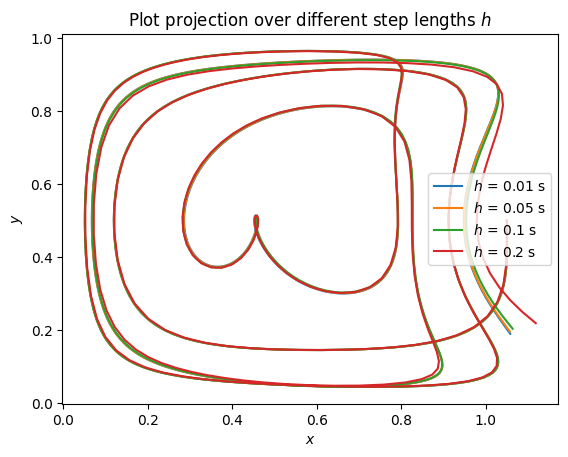

In [51]:
for h in [0.01, 0.05, 0.1, 0.2]:
    [t_array, val_array] = heun(func, val_0, 0, 50, h)
    plt.plot(val_array[:,0,:], val_array[:,1,:], label = rf'$h$ = {h} s')

plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Plot projection over different step lengths $h$ ')
plt.show()

# 1b
tekst til 1b

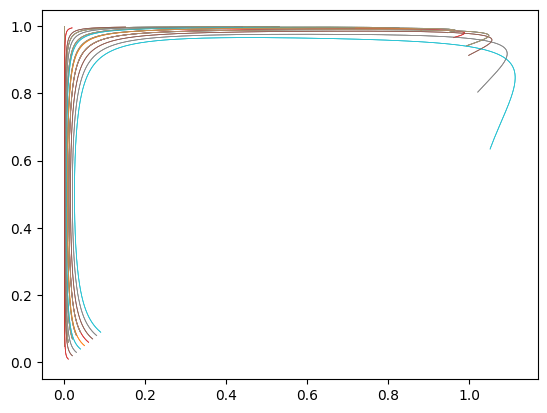

In [52]:
# code for 1b
N_p = 100
N_ps = int(np.sqrt(N_p))
xmax = 0.1
ymax = 0.1
t_start = 0
t_end = 10
iterations = 1000
h = (t_end-t_start)/iterations
if N_p!=N_ps**2:
    print("Invalid dimensions")
else:
    grid = np.array([(i/N_ps*xmax,j/N_ps*ymax)for i in range(N_ps) for j in range(N_ps)]).reshape(2,N_p)

t,x = heun(func, grid, t_start, t_end, h)

plt.plot(x[:,0,:], x[:,1,:], alpha=0.5, lw=0.5)
plt.show()

# 1c
tekst til 1c

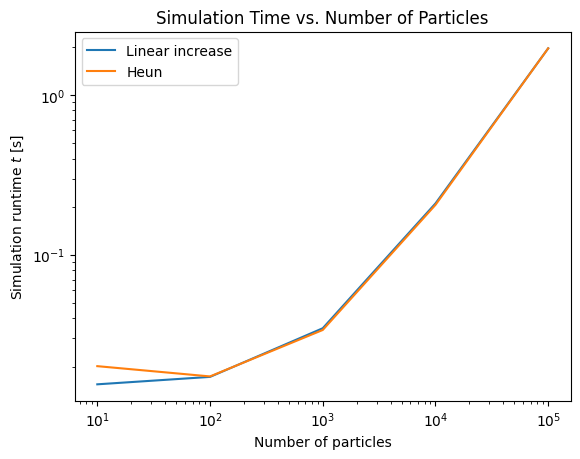

In [40]:
N_p = np.array([10, 10**2, 10**3, 10**4, 10**5])
times = []
for N_iter in N_p:
    start_time = time()
    heun(func, np.array([val_0]*N_iter).transpose(), 0, 50, 0.1)
    end_time = time()
    times.append(end_time-start_time)

def linear_func(x):
    [a, b] = np.polyfit(N_p, times, 1)
    return a*x+b

plt.plot(N_p, linear_func(N_p), label = "Linear increase")
plt.loglog(N_p, times, label = "Heun")
plt.xlabel("Number of particles")
plt.ylabel(r'Simulation runtime $t$ [s]')
plt.title(r'Simulation Time vs. Number of Particles')
plt.legend()
plt.show()


# 2a

Her har vi med både strømninger og vind med f_w = 0.03

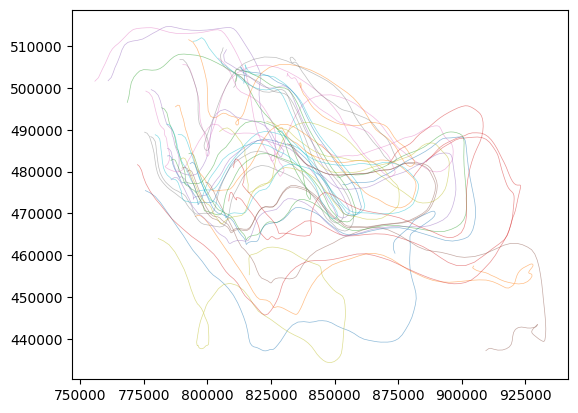

In [41]:
f_w = 0.03
h = 3600 # seconds
N_p = 30 # suitable, så ikke lang tid

# random initial conditions
coords = np.random.normal(490000, 10000, (2,N_p))
coords[0,:] += 300000
d  = xr.open_dataset('./NorKyst-800m.nc')
f  = Interpolator(dataset = d)

t, vals = heun(f, coords, 0, 3600*24*5, 3600)

plt.plot(vals[:,0,:], vals[:,1,:], alpha=0.5, lw=0.5)
plt.show()

###############################################################################################################333

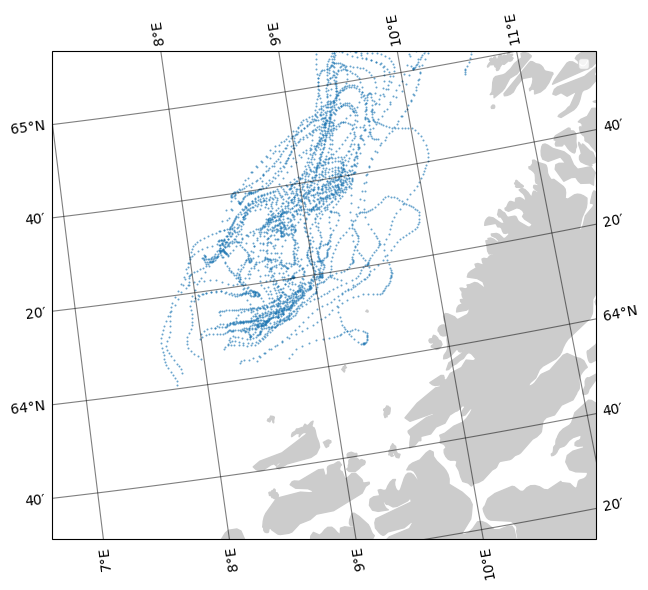

In [46]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

# scatter plot positions, note the extra transform keyword
# ax.scatter(vals[:,0,:], vals[:,1,:], s=1, transform=npstere, lw=.5, alpha=.5)
ax.plot(vals[:,0,:], vals[:,1,:], transform=npstere, lw=.5, alpha=.5)   
ax.scatter(vals[0,0,:], vals[0,1,:], transform=npstere, color = "blue", label = "start position", s = 0.3)
ax.scatter(vals[-1,0,:], vals[-1,1,:], transform=npstere, color = "red", label = "end position", s = 0.3)



# # Make outline a bit larger
ax.set_extent((7,11,63.5,65))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k')

ax.legend()
plt.tight_layout()
plt.show()

# 2b

In [ ]:
# code for 2b

# 3a

In [ ]:
N_p = 10
t_0 = 0
t_end = 3 * 24 * 3600
h = 3600

coords = np.random.normal(250000, 10000, (N_p, 2))
coords[:,1] += 210000

# plot of distribution of stranded particles

# plot of percentage of all particles that are stranded as a function of time

# 3b

In [ ]:
# different windage factors
for f_w in [0, 0.05, 0.1, 0.15]:
    print(f_w)

0
0.05
0.1
0.15


# conclusion